In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

<ipython-input-58-7ea5b047c4dc>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Ice Cream Production Data

In [43]:
#read data
df_ice_cream = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time series data/ice_cream.csv')

In [44]:
df_ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [45]:
#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

In [46]:
#convert date column to datetime type
df_ice_cream['date'] = pd.to_datetime(df_ice_cream.date)

In [47]:
#set date as index
df_ice_cream.set_index('date', inplace=True)

In [48]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
df_ice_cream = df_ice_cream[start_date:]

In [49]:
#show result
df_ice_cream.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


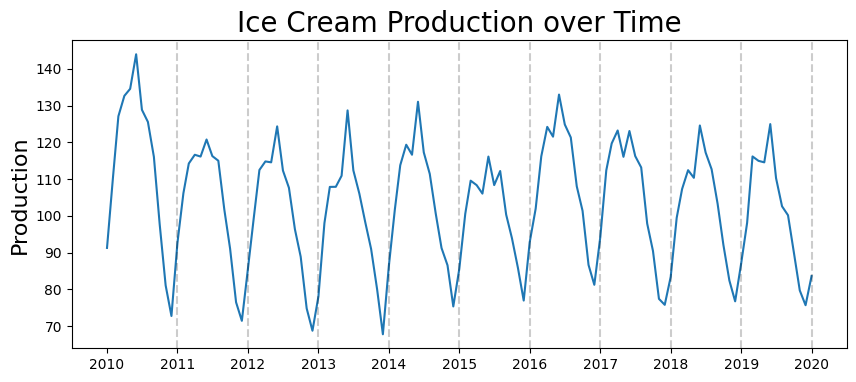

In [50]:
plt.figure(figsize=(10,4))
plt.plot(df_ice_cream.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# ACF

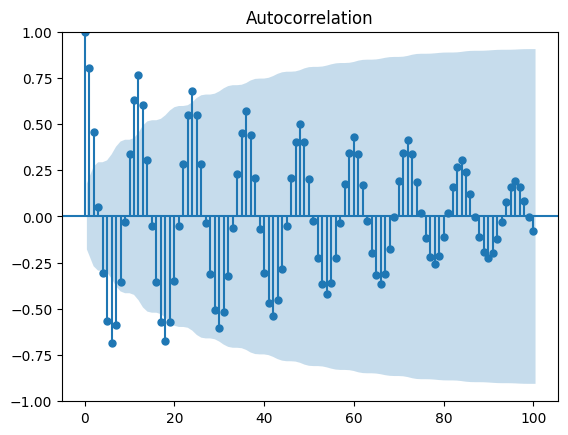

In [51]:
acf_plot = plot_acf(df_ice_cream.production, lags=100)

## Based on decaying ACF, we are likely dealing with an Auto Regressive process

# PACF

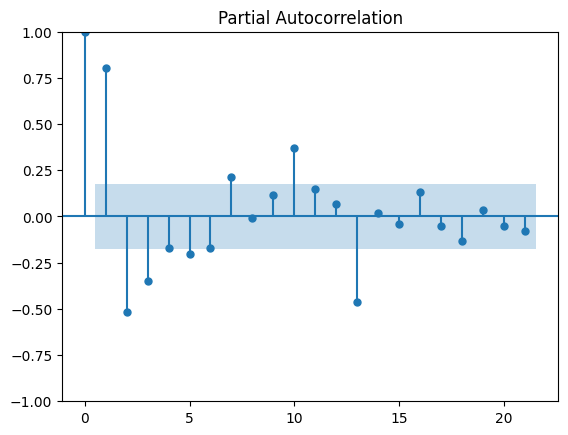

In [52]:
pacf_plot = plot_pacf(df_ice_cream.production)

## Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3, 10, 13

In [54]:
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = df_ice_cream[df_ice_cream.index <= train_end]['production']
test_data = df_ice_cream[(df_ice_cream.index > train_end) & (df_ice_cream.index <= test_end)]['production']

# Print the shapes of train and test sets
print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)


Train set shape: (108,)
Test set shape: (12,)


# AR Model

In [61]:
model = ARIMA(train_data, order= (3,0,0))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [64]:

# Fit the ARIMA model
start_time = time()  # Record start time
model_fit = model.fit()
end_time = time()  # Record end time

# Print the summary of the model
print(model_fit.summary())

# Print the time taken for model fitting
print("Time taken for model fitting:", end_time - start_time, "seconds")


                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Fri, 26 Jan 2024   AIC                            758.170
Time:                        13:08:22   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [65]:
# Get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [66]:
# Get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions


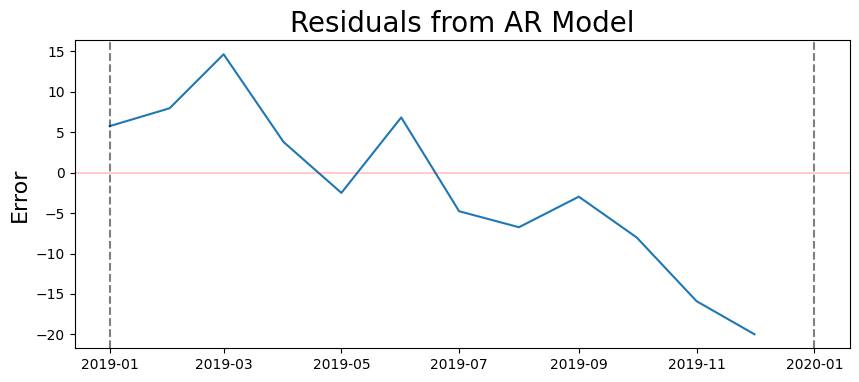

In [67]:
# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='-', alpha=0.2)

# Add vertical lines for years
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.5)

plt.show()


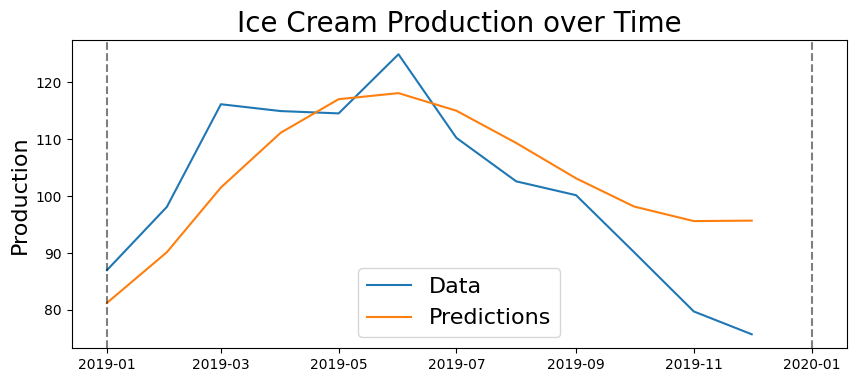

In [70]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)

# Plot predictions
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)

# Add vertical lines for years
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.5)

plt.show()


In [71]:
mape = np.mean(abs(residuals / test_data))
print('Mean Absolute Percent Error:', round(mape, 4))

Mean Absolute Percent Error: 0.0895


In [72]:
rmse = np.sqrt(np.mean(residuals**2))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 9.88415874539594


In [ ]:
z